# Chapter 17. Decision Trees

In [19]:
from __future__ import division
from collections import Counter, defaultdict
from functools import partial
import math, random
import matplotlib.pyplot as plt
import numpy as np

DataSciencester's VP of Talent has interviewed a number of job candidates from the site, with varying degrees of success.  
He's collected a data set consisting of several (qualitative) attributes of each candidate, as well as whether that candidate interviewed well or poorly.  
Could you, he asks, use this data to build a model identifying which candidates will interview well, so that he doesn't have to waste time conducting interviews?  
This task seems like a good fit for a [decision tree](https://en.wikipedia.org/wiki/Decision_tree), which is another predictive modeling tool in the data scientist's kit.

## What is a Decision Tree?

A decision tree uses a tree structure to represent a number of possible [decision paths](http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html) and an outcome for each path.  
If you have ever played the game [Twenty Questions](https://en.wikipedia.org/wiki/Twenty_Questions), then you are familiar with decision trees and how they work.

Decision trees have a lot to recommend them.  
They are very easy to understand and interpret, and the process by which they reach a prediction is very transparent.  
Decision trees can easily handle a mix of numeric and categorical attributes as well as classify data for which attributes are missing.  

However, finding an "optimal" decision tree for a set of training data is computationally a very hard problem.  
We will work around this problem by trying to build a good-enough tree rather than an optimal one, although for large data sets this can still be a lot of work.  
More importantly, it is very easy (and very bad) to build decision trees that are [overfitted](https://en.wikipedia.org/wiki/Overfitting) to the training data, and that don't generalize well to unseen data.  
We'll look at ways to address this.

Decision trees are often divided into [classification trees](http://www.stat.wisc.edu/~loh/treeprogs/guide/wires11.pdf), which produce categorical outputs, and [regression trees](http://www.stat.wisc.edu/~loh/treeprogs/guide/wires11.pdf), which produce numeric outputs.  
In this chapter, we will focus on classification trees.  
We'll work through the [ID3 algorithm](https://en.wikipedia.org/wiki/ID3_algorithm) for learning a decision tree from a set of labeled data, which should help us understand how decision trees actually work.  
To make things simple, we'll restrict ourselves to problems with binary outputs like, "Should I hire this candidate?"

## Entropy

In order to build a decision tree, we will need to decide what questions to ask and in what order.  
At each stage of the tree there are some possibilities that we have eliminated and some that we haven't.  
After learning that an animal doesn't have more than five legs, we've eliminated the possibility that it's a grasshopper, but we haven't eliminated the possibility that it's a duck.  
Every possible question partitions the remaining possibilities according to their answers.  
Ideally, we would like to choose questions whose answers give a lot of information about what our tree should predict.  
If there is a single yes/no question for which "yes" answers always correspond to `True` outputs and "no" answers to `False` outputs (or vice versa), this would be an awesome question to pick.
We capture this notion of "how much information" with [entropy](https://en.wikipedia.org/wiki/Maximum_entropy_probability_distribution), a term that we will use to represent the uncertainty associated with data.

Imagine that we have a set $S$ of data, each member of which is labeled as belonging to one of a finite number of classes $C_1,\;\ldots,\;C_n$.  
If all of the data points belog to a single class, then there is no real uncertainty, which means we'd like there to be low entropy.  
If the data points are evenly spread across the classes, then there is a lot of uncertainty, and we'd like there to be high entropy.

In math terms, if $p_i$ is the proportion of data labeled as class $C_i$, we define the entropy as:  

$\Large H(S) = -\;p_1\text{log}_2p_1 - \;\ldots\; - p_n\text{log}_2p_n$  

with the (standard) convention that $0\;\text{log}\;0 = 0$.  
The following plot should aid your understanding:

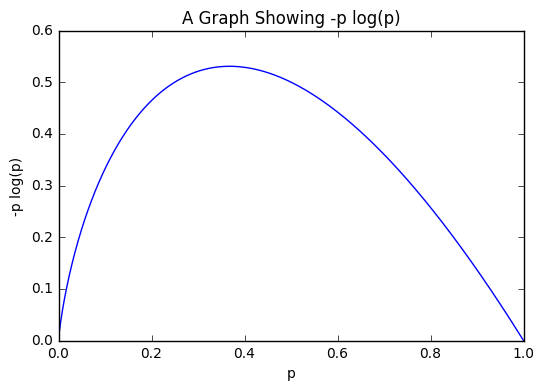

In [20]:
xs = np.linspace(0.0001, 1.0, 1000)
# xs = np.arange(0.001, 1.0, 0.001)  also works
ys = -xs * np.log2(xs)
plt.title("A Graph Showing -p log(p)")
plt.xlabel("p")
plt.ylabel("-p log(p)")
plt.plot(xs, ys)
plt.show()

Without worrying too much about the details, each term $-p_i\text{log}_2p_i$ is non-negative and is close to zero precisely when $p_i$ is either close to zero or close to one.  
This means that the entropy will be small when every $p_i$ is close to 0 or 1 (like when most of the data is in a single class), and it will be larger when many of the $p_i$'s are not too close to 0 (like when the data is spread across multiple classes).  
This is exactly the behavior that we desire, and it is simple enough to roll all of this into a function:

In [21]:
def entropy(class_probabilities):
    """ given a list of class probabilities, calculate the entropy """
    return sum(-p * math.log(p, 2) for p in class_probabilities if p)  # if p means ignore zero probabilities 

Our data will consist of pairs (`input`, `label`), which means that we will need to compute the class probabilities ourselves.  
Observe that we don't actually care which label is associated with each probability, only what the probabilites are:

In [22]:
def class_probabilities(labels):
    total_count = len(labels)
    return [count / total_count for count in Counter(labels).values()]

def data_entropy(labeled_data):
    labels = [label for _, label in labeled_data]
    probabilities = class_probabilities(labels)
    return entropy(probabilities)

## The Entropy of a Partition

What we have done so far is calculate the entropy ("uncertainty") of a single set of labeled data.  
Each stage of a decision tree involves asking a question whose answer partitions data into one or (hopefully) more subsets.  
As an example, our "does it have more than five legs?" question partitions animals into those that have more than 5 legs and those that don't.  
We would also like some idea of the entropy that results from partitioning a set of data in a certain way.  
We want a partition to have low entropy if it splits the data into subsets that themselves have low entropy (high certainty), and high entropy if the data contains subsets that are large and have low certainty.

Mathematically, if we partition our data $S$ into subsets $S_1,\;\ldots,\;S_m$ containing proportions $q_1,\;\ldots,\;q_m$ of the data, then we can calculate the entropy of the partition as a weighted sum:  

$\Large H = q_1H(S_1) + \;\ldots\;+ q_mH(S_m)$  

which can be implemented as:

In [23]:
def partition_entropy(subsets):
    """ find the entropy from this partition of data into subsets """
    """ subsets is a list of lists of labeled data """
    total_count = sum(len(subset) for subset in subsets)
    return sum(data_entropy(subset) * len(subset) / total_count for subset in subsets)

**Note**  
One problem with this approach is that partitioning by an attribute with many different values will result in a very low entropy due to overfitting.  
For example, imagine that you work for a bank and you are trying to build a decision tree to predict which of your customers are likely to default on their mortgages, using some historical data as your training set.  
This example data contains each customer's Social Security Number.  
Partitioning on SSN will produce one-person subsets, each of which has zero entropy.  
However, a model that relies on SSN will not generalize beyond the training set.  
For this reason, try to avoid (or at least bucket, if appropriate) attributes with large numbers of possible values when creating decision trees.

## Creating a Decision Tree

The VP provides you with the interviewee data, consisting of pairs (`input`, `label`), where each `input` is a `dict` of candidate attributes, and each label is either `True` (the candidate interviewed well) or `False` (the candidate interviewed poorly).  
In particular, you are provided with each candidate's level, her preferred language, whether she is active on Twitter, and whether she has a PhD:

In [24]:
inputs = [
    ({'level':'Senior','lang':'Java','tweets':'no','phd':'no'},   False),
    ({'level':'Senior','lang':'Java','tweets':'no','phd':'yes'},  False),
    ({'level':'Mid','lang':'Python','tweets':'no','phd':'no'},     True),
    ({'level':'Junior','lang':'Python','tweets':'no','phd':'no'},  True),
    ({'level':'Junior','lang':'R','tweets':'yes','phd':'no'},      True),
    ({'level':'Junior','lang':'R','tweets':'yes','phd':'yes'},    False),
    ({'level':'Mid','lang':'R','tweets':'yes','phd':'yes'},        True),
    ({'level':'Senior','lang':'Python','tweets':'no','phd':'no'}, False),
    ({'level':'Senior','lang':'R','tweets':'yes','phd':'no'},      True),
    ({'level':'Junior','lang':'Python','tweets':'yes','phd':'no'}, True),
    ({'level':'Senior','lang':'Python','tweets':'yes','phd':'yes'},True),
    ({'level':'Mid','lang':'Python','tweets':'no','phd':'yes'},    True),
    ({'level':'Mid','lang':'Java','tweets':'yes','phd':'no'},      True),
    ({'level':'Junior','lang':'Python','tweets':'no','phd':'yes'},False)
]

Our tree will consist of *decision nodes*, which ask us a question and direct us differently depending on the answer, and *leaf nodes*, which give us a prediction.  
We will build it using the relatively simple [ID3 algorithm](https://en.wikipedia.org/wiki/ID3_algorithm) (yes, I linked it again), which operates in the following manner:

Let's say that we're given some labeled data, and a list of attributes to consider branching on.  
- If the data all have the same label, then create a leaf node that predicts that label and then stop.
- If the list of attributes is empty (meaning there are no more possible questions to ask), then create a leaf node that predicts the most common label and stop.
- Otherwise, try partitioning the data by each of the attributes.
- Choose the partition with the lowest partition entropy.
- Add a decision noode based on the chosen attribute.
- Recur on each partitioned subset using the remaining attributes.

This is what's known as a [greedy algorithm](https://en.wikipedia.org/wiki/Greedy_algorithm), because at each step it makes the locally optimal choice (first best option).  
Given a data set, there may be a better tree with a worse-looking first move.  
If so, this algorithm won't find it.  
Nonetheless, ID3 is relatively easy to understand and implement, which makes it a good place to begin exploring decision trees.

Let's manually go through these steps on the interviewee data set.  
The data set has bot `True` and `False` labels, and we have four attributes that we can split on.  
Our first step will be to find the partition with the least entropy.  
We'll start by writing a function that does the partitioning:

In [25]:
def partition_by(inputs, attribute):
    """ each input is a pair (attribute_dict, label) """
    """ returns a dict : attribute_value -> inputs """
    groups = defaultdict(list)
    for input in inputs:
        key = input[0][attribute]   # get the value of the specified attribute
        groups[key].append(input)   # then add this input to the correct list
    return groups

as well as a function that uses it to calculate entropy:

In [26]:
def partition_entropy_by(inputs, attribute):
    """ calculates the entropy corresponding to the given partition """
    partitions = partition_by(inputs, attribute)
    return partition_entropy(partitions.values())

Then we just need to find the minimum-entropy partition for the whole data set:

In [27]:
for key in ['level', 'lang', 'tweets', 'phd']:
    print key, partition_entropy_by(inputs, key)

level 0.693536138896
lang 0.860131712855
tweets 0.788450457308
phd 0.892158928262


The lowest entropy comes from splitting on `level`, so we'll need to make a subtree for each possible `level` value.  
Every `Mid` candidate is labeled `True`, which means that the `Mid` subtree is simply a leaf node predicting `True`.  
For `Senior` candidiates, we have a mix of `True`s and `False`s, so we need to split again:

In [28]:
senior_inputs = [(input, label) for input, label in inputs if input["level"] == "Senior"]
for key in ['lang', 'tweets', 'phd']:
    print key, partition_entropy_by(senior_inputs, key)

lang 0.4
tweets 0.0
phd 0.950977500433


The results show us that our next split should be on `tweets`, which results in a zero-entropy partition.  
For these Senior-level candidates, "yes" on `tweets` always result in `True`, while "no" on `tweets` always result in `False`.  
Finally, if we do the same thing for the `Junior` candidates, we end up splitting on `phd`, after which we find that no PhD always results in `True` and (yes on) PhD always results in `False`.  
The following easy-to-read visualization shows the complete decision tree:

![decision_tree](img/decision_tree.png)

## Putting It All Together

Now that we've seen how the algorithm works, we would like to implement it more generally.  
This means that we need to decide how we want to represent trees.  
Let's keep things simple and define *tree* as one of the following:  
- `True`
- `False`
- a tuple (`attribute`, `subtree_dict`)  

Here `True` represents a leaf node that returns `True` for any input, `False` represents a leaf node that returns `False` for any input, and a tuple represents a decision node that, for any input, finds it `attribute` value, and classifies the input using the corresponding subtree.  

With this representation, our hiring tree would look like:

There's still the question of what to do if we encounter an unexpected (or missing) attribute value.  
What should our hiring tree do if it encounters a candidate whose `level` is "Intern"?  
We can handle this case by adding a `None` key that predicts the most common label (although this is a bad idea if `None` is actually a that appears in the data).  
Given such a representation, we can classify an input with:

In [29]:
def classify(tree, input):
    """ classify the input using the given decision tree """
    # if this is a leaf node, return its value
    if tree in [True, False]:
        return tree
    # otherwise this tree consists of an attribute to split on and a dictionary whose keys are 
    # values of that attribute and whose values are the subtrees to consider next
    attribute, subtree_dict = tree
    
    subtree_key = input.get(attribute)   # None if input is missing the attribute
    
    if subtree_key not in subtree_dict:  # if there is no subtree for key,
        subtree_key = None               # use the None subtree
        
    subtree = subtree_dict[subtree_key]  # choose the appropriate subtree,
    return classify(subtree, input)      # and use it to classify the input

Now we just have to build the tree representation from our training data:

In [30]:
def build_tree_id3(inputs, split_candidates=None):
    # if this is our first pass, all keys of the first input are split_candidates
    if split_candidates is None:
        split_candidates = inputs[0][0].keys()
        
    # count Trues and Falses in the inputs
    num_inputs = len(inputs)
    num_trues = len([label for item, label in inputs if label])
    num_falses = num_inputs - num_trues
    
    if num_trues == 0: return False     # if no 'Trues' then return a 'False' leaf
    if num_falses == 0: return True     # if no 'Falses' then return a 'True' leaf
    if not split_candidates:            # if there are no split candidates left
        return num_trues >= num_falses  # return the majority leaf
    
    # otherwise, split on the best attribute
    best_attribute = min(split_candidates, key=partial(partition_entropy_by, inputs))
    partitions = partition_by(inputs, best_attribute)
    new_candidates = [a for a in split_candidates if a != best_attribute]
    
    # and recursively build the subtrees
    subtrees = { attribute_value : build_tree_id3(subset, new_candidates) 
                for attribute_value, subset in partitions.iteritems() }
    subtrees[None] = num_trues > num_falses  # default case
    
    return (best_attribute, subtrees)

In the tree that we built, every leaf consisted entirely of `True` inputs or entirely of `False` inputs.  
This means that the tree predicts perfectly on the training data set:

In [31]:
tree = build_tree_id3(inputs)
tree

('level',
 {None: True,
  'Junior': ('phd', {None: True, 'no': True, 'yes': False}),
  'Mid': True,
  'Senior': ('tweets', {None: False, 'no': False, 'yes': True})})

However, we can also apply our model to new data that was not in the training set:

In [32]:
classify(tree, { "level" : "Junior",
                 "lang" : "Java",
                 "tweets" : "yes",
                 "phd" : "no"} )

True

In [33]:
classify(tree, { "level" : "Junior",
                 "lang" : "Java",
                 "tweets" : "yes",
                 "phd" : "yes"} )

False

as well as data with missing or unexpected values:

In [34]:
classify(tree, { "level" : "Intern" } )

True

In [35]:
classify(tree, { "level" : "Senior" } )

False

**Note**  
Since our goal was mainly to demonstrate *how* to build a tree, we built the tree using the entire data set.  
As always, if we were really trying to create a good model for something, we would have collected more data and split it into train/validation/test subsets.

## Random Forests

Given how closely decision trees can fit themselves to their training data, it's not surprising that they have a tendency to overfit.  
One way of avoiding this is a technique called [random forests](https://en.wikipedia.org/wiki/Random_forest), in which we build multiple decision trees and let them 'vote' on how to classify inputs:

In [36]:
def forest_classify(trees, input):
    votes = [classify(tree, input) for tree in trees]
    vote_counts = Counter(votes)
    return vote_counts.most_common(1)[0][0]

Our tree-building process was deterministic, so how do we get random trees?  
One piece involves bootstrapping data (see [Digression: The Bootstrap](http://localhost:8888/notebooks/15_Chapter_Multiple_Regression.ipynb#Digression:-The-Bootstrap)).  
Rather than training each tree on all of the `inputs` in the training set, we instead train each tree on the result of `bootstrap_sample(inputs)`.  
Since each tree is built using different data, each tree will be different from every other tree.  
One side benefit of this practice is that it's totally fair to use the nonsampled data to test each tree, which means that you can get away with using all of your data as the training set if you are careful (and clever) about how you measure performance.  
This technique is known as [*bootstrap aggregating* or *bagging*](https://en.wikipedia.org/wiki/Bootstrap_aggregating).

A second source of randomness involves changing the way we chose the `best_attribute` to split on.  
Rather than looking at all of the remaining attributes, we first choose a random subset of them and then split on whichever of those is best:

This is an example of a broader technique called [ensemble learning](https://en.wikipedia.org/wiki/Ensemble_learning) in which we combine several [weak learners](https://stats.stackexchange.com/questions/82049/what-is-meant-by-weak-learner) (typically high-bias, low-variance models) in order to produce an overall strong model.  

## For Further Exploration

scikit-learn has many [Decision Tree models](http://scikit-learn.org/stable/modules/tree.html).  
It also has an [ensemble module](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) that includes a `RandomForestClassifier` as well as other ensemble methods.  
We barely scratched the surface of decision trees and their algorithms.  
[Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning) is a good starting point for further exploration.